In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist
from IPython.display import clear_output
import copy
import time
import sys
import os

sys.path.append(os.path.join("..", "src"))
import math
import wandb
import argparse
from utils import Loss
from dataloader import load_fashion_mnist, load_mnist
from model import NeuralNet
from optimizer import GradientDescent
import json
from utils import confusion_matrix

2025-03-17 19:53:02.415565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 19:53:02.416113: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 19:53:02.418439: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 19:53:02.424705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742221382.435019  510878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742221382.43

In [2]:
with open("../config.json", "r") as f:  # Reading sweep config file
    sweep_config = json.load(f)

wandb_project = "mnist"
wandb_entity = "config1"

wandb.init(
    project=wandb_project,
    name=wandb_entity,
    config=sweep_config,
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bt23s013 (deeplearn24) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


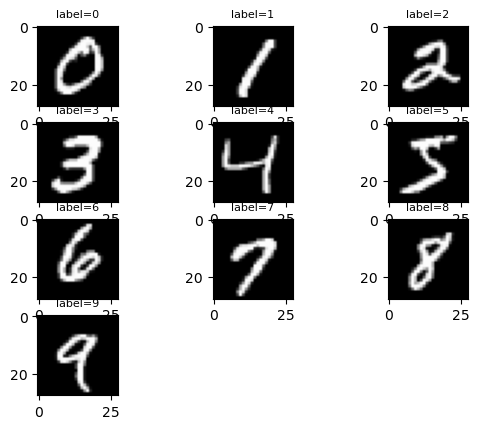

In [4]:
# Loading the dataset
train, valid, test = load_mnist(sweep_config['batch_size'])


Epoch: 0, Train Loss: 0.4081196992871422, Valid Loss: 0.20999257334756966, Valid Accuracy: 0.9376662234042553
Time taken: 6.449070453643799 seconds
Epoch: 1, Train Loss: 0.16309127703772758, Valid Loss: 0.15073199710309423, Valid Accuracy: 0.9571143617021277
Time taken: 6.366389513015747 seconds
Epoch: 2, Train Loss: 0.121916194746727, Valid Loss: 0.13363654101056033, Valid Accuracy: 0.9627659574468085
Time taken: 6.360590934753418 seconds
Epoch: 3, Train Loss: 0.0984257307011934, Valid Loss: 0.1263424711190777, Valid Accuracy: 0.9652593085106383
Time taken: 6.7794928550720215 seconds
Epoch: 4, Train Loss: 0.08248843731900159, Valid Loss: 0.12011112062483927, Valid Accuracy: 0.9670877659574468
Time taken: 6.556470632553101 seconds
Epoch: 5, Train Loss: 0.07016746218016941, Valid Loss: 0.1166355965214624, Valid Accuracy: 0.9669215425531915
Time taken: 6.797358274459839 seconds
Epoch: 6, Train Loss: 0.060681299156308634, Valid Loss: 0.12402920026397055, Valid Accuracy: 0.9662566489361702

epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇████
train/batch_loss,▇▆▆▂▅▂█▅▂▄▂▂▃▃▂▄▂▁▂▁▂▁▃▁▂▇▁▂▂▁▁▂▁▁▁▂▁▂▁▁
train/loss,█▃▃▂▂▂▁▁▁▁
val/accuracy,▁▅▇▇▇▇▇██▇
val/loss,█▄▂▂▁▁▂▁▂▂
epoch,10
test_accuracy,0.9683
train/accuracy,0.98956
train/batch_loss,0.00073
train/loss,0.0394


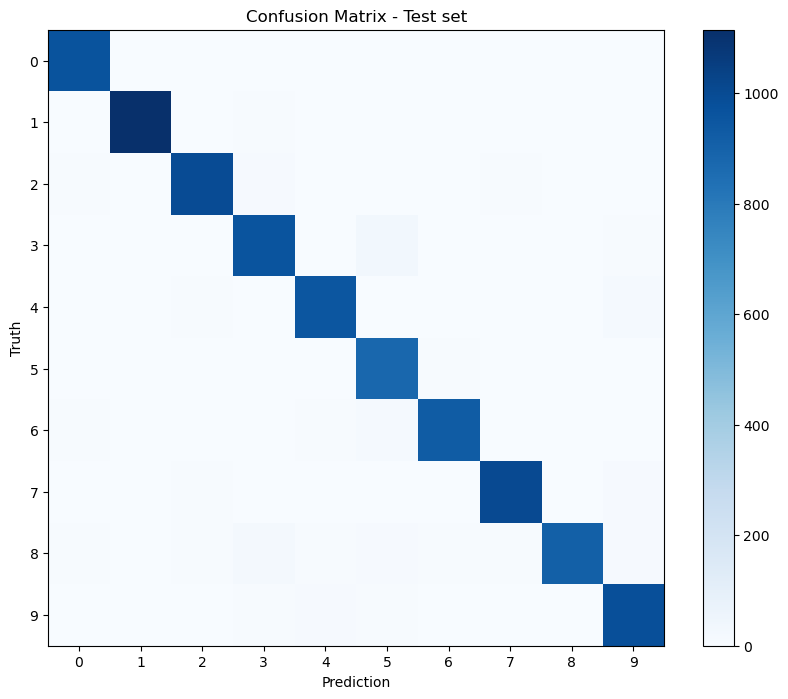

In [5]:
# Training the model
threshold = 1  # Clipping threshold for gradient clipping
loss = Loss(loss_fn=sweep_config["loss"])
optimizer = GradientDescent(
    optimizer=sweep_config["optimizer"],
    lr=sweep_config["learning_rate"],
    clipping_threshold=threshold,
    momentum=sweep_config["momentum"],
    beta=sweep_config["beta"],
    beta1=sweep_config["beta1"],
    beta2=sweep_config["beta2"],
    epsilon=sweep_config["epsilon"],
)
model = NeuralNet(
    input_size=784,
    hidden_size=sweep_config["hidden_size"],
    output_size=10,
    n_hidden=sweep_config["num_layers"],
    loss=loss,
    activation=[sweep_config['activation'], "softmax"],
    weight_init=sweep_config["weight_init"],
    weight_decay=sweep_config["weight_decay"],
)
i = 0

for epoch in range(sweep_config["epochs"]):

    batch_train_loss = []
    batch_valid_loss = []
    batch_train_accuracy = []
    batch_valid_accuracy = []
    start = time.time()

    for x, y in train:
        loss, accuracy = optimizer.optimize(model, x, y, i)
        batch_train_loss.append(loss)
        batch_train_accuracy.append(accuracy)
        wandb.log({"train/batch_loss": loss})

        i += 1

    for x_val, y_val in valid:
        valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
        batch_valid_loss.append(valid_loss)
        batch_valid_accuracy.append(valid_accuracy)

    wandb.log(
        {
            "epoch": epoch + 1,
            "train/loss": np.mean(batch_train_loss),
            "train/accuracy": np.mean(batch_train_accuracy),
            "val/loss": np.mean(batch_valid_loss),
            "val/accuracy": np.mean(batch_valid_accuracy),
        }
    )
    print(
        f"Epoch: {epoch}, Train Loss: {np.mean(batch_train_loss)}, Valid Loss: {np.mean(batch_valid_loss)}, Valid Accuracy: {np.mean(batch_valid_accuracy)}"
    )
    end = time.time()
    print(f"Time taken: {end-start} seconds")

# Testing the model

_, _, test_acc = model(test[0], test[1])
print(f"Test Accuracy: {test_acc}")
predictions = np.argmax(model.predict(test[0]), axis=1)
true = np.argmax(test[1], axis=1)
wandb.summary["test_accuracy"] = test_acc
conf = confusion_matrix(true, predictions)
plt.figure(figsize=(10, 8))
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test set')
plt.colorbar()
tick_marks = np.arange(len(np.unique(true)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('Truth')
plt.xlabel('Prediction')
wandb.log({"Confusion matrix": wandb.Image(plt)})

wandb.finish()
